In [ ]:
# https://www.kaggle.com/competitions/ashrae-energy-prediction/overview

# Load Packages and Import Data

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# Find our directory
directory = !dir
for d in directory:
    if "Directory" in d:
        path = d[14:]
path = path.replace('\\', '/')

# read each table to dataframe
all_data = {}

for f in glob.glob(f"{path}/ashrae-energy-prediction/*"):
    filename=f.split("\\")[1][:-4]
    file_path = f"{path}/ashrae-energy-prediction/{filename}.csv"
    file_size = os.path.getsize(file_path)

    print(f"File/Size: {filename} / {file_size/1024/1024:.1f} MB")    
    
    df = pd.read_csv(f"{file_path}")
    all_data[filename] = df

all_data.keys()

In [ ]:
df_meta = all_data['building_metadata']
df_train = all_data['train']
df_test = all_data['test']
df_w_train = all_data['weather_train']
df_w_test = all_data['weather_test']
df_sample = all_data['sample_submission']

df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

df_w_train['timestamp'] = pd.to_datetime(df_w_train['timestamp'])
df_w_test['timestamp'] = pd.to_datetime(df_w_test['timestamp'])

# Fix for site 0 electric meter reading
# Site 0 type 0 (electric meter) are reported in kBTU when it should be kWh. This affects both training data and test data (need to convert prediction output back to kBTU).
# Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring.
wrong_unit_bid = set(df_meta[df_meta.site_id==0].building_id) #get site 0 building ids.
df_train[df_train.building_id.isin(wrong_unit_bid)]
df_train.loc[(df_train.building_id.isin(wrong_unit_bid)) & (df_train.meter == 0), 'meter_reading'] = df_train['meter_reading']*0.2931

In [33]:
# Define standard functions

# Temperature Conversions
def FtoC(F):
    return round((F-32)*5/9,2)

def CtoF(C):
    return round((9/5)*C+32,2)

# Value count and %
def vc(df, feature):
    value_counts = df[feature].value_counts()
    value_percentages = df[feature].value_counts(normalize=True) * 100.0
    cumulative_percentages = value_percentages.cumsum()
    result = pd.DataFrame({'Count': value_counts, 'Percentage': value_percentages, 'Cumulative Percentage': cumulative_percentages})
    return result

# For each category in feature 1, get unique categories of feature 2
def unique_for_each_category(df,feature1, feature2):
    df1 = df[[feature1, feature2]].groupby(by = feature1, as_index=False).agg(lambda x: list(x))
    df1['unique'] = df1[feature2].apply(lambda x:set(x))
    df1['unique_length'] = df1['unique'].apply(lambda x:len(x))
    return df1    

# EDA

## General Overview

In [ ]:
display(df_meta.describe())
display(df_meta.info())
display(df_meta.head())

# 15 sites for 1449 buildings
# 1449 - 675 null data for year-built
# 1449 - 355 null data for floor count

In [ ]:
display(df_train.describe())
display(df_train.info())
display(df_train.head())

display(df_test.describe())
display(df_test.info())
display(df_test.head())

In [ ]:
display(df_w_train.describe())
display(df_w_train.info())
display(df_w_train.head())

display(df_w_test.describe())
display(df_w_test.info())
display(df_w_test.head())

## Questions

In [ ]:
## Questions for Meta Data
# What's the distribution of primary_use? 
# Do buildings and site have the same primary use?   doubt it...
# What's the average square feet for each primary use type? 
# Are there any correlations between each of these numerical features
# Can 2 or more sites have the same building ids?

## Questions for train/test data
# Are there correlations between meter and meter_reading?  Sum of energy per meter
# what is distribution of meter type? (value counts)
# Are the same building_id in train and test data?  Or will we predict new buildngs?
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour? 


## Questions for Weather data
# What is max and min?
# Do we need to consider climate change?  Would weather data drift in future affect model?
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour?

########################################################################################################
########################################################################################################
########################################################################################################

## Questoins for Joined Data
# airtemp: Which require more energy?  +10C from normal or -10C from normal?       19C to 24C  = normal human comfort temp
# cloud: confirm: high cloud + high air temp = low energy.  low cloud + low air temp = low energy.  Vice versa
# dew temp: if dew = air, = high humidity.  = more energy
# precip: high precip = low energy?  
# wind speed: high speed = low energy if hot and high energy if cold

# how does sea level pressure affect energy?  google research this.  ANS: higher pressure = stagnant air = more ventilation(?).  low pressure = lower air density, affect cooling efficiency. low pressure = more air leakage
# how does wind direction affect energy?  gooogle sesarch this. ANS: against building = more convection, paralle building = shield/insulation,  can also introduce air if windows are perpendicular to wind

# Idea, do we need 4 models, 1 for each meter?
# Idea, do we need to cluster building_id's and create separate models?  
# Feature Idea, energy per sqft to help with clustering of buildings
# Idea, How do we check if electricity meter includes plug loads like computers or occupancy?  This generates heat too... helps in winter
# Idea, How do we check if hot water is just for heating/cooling or also to provide hot water for faucets or showers? 
# Feature idea: dew temp / air temp or dew temp - air temp

## Meta Data

In [ ]:
df_meta.head(1)

In [ ]:
### What's the distribution of primary_use?   
### ANS:  mostly Education, then Offices, Entertainment/public assembly, public services.  These make up 80% of buildings.  
df_meta_primaryuse_vc = vc(df_meta, 'primary_use')
display(df_meta_primaryuse_vc)

In [ ]:
### Do buildings and site have the same primary use?   doubt it...  

# Check if sites have multiple primary use types.  ANS: Sites have multiple primary use types
sid = df_meta.site_id.sample(1).values[0] #randomly sample a site
print(f'Site {sid} unique primary use types: {df_meta[df_meta.site_id==sid].primary_use.unique()} \n')

# Check if buildings have multiple primary use types.  ANS: Buildings only have 1 primary use type
for bid in range(df_meta.building_id.nunique()):                 
    unique_primaryuse = df_meta[df_meta.building_id==bid].primary_use.unique()
    
    # if each building has more than 1 or less than 1 primary use type, print the building id.  Else, all buildings have only 1 primary use type.
    if len(unique_primaryuse) > 1:
        print(f'Building {bid} unique primary use types: {unique_primaryuse}')
    elif len(unique_primaryuse) < 1:
        print(f'Building {bid} unique primary use types: {unique_primaryuse}')

In [ ]:
# What's the average square feet for each primary use type? 
# ANS: ON AVERAGE:
# Parking is largest followed by Services, Healthcare, and Education. Religious worship is smallest
# 1939 (Technology/science is oldest) through 2012 (Food sales and service)   <---- may want to bin on building age...
# Floors range from 1 to 6.  <-- may want to bin 1 floor versus multiple floor.  1 floor has roof load.  2 floor, roof load splits to 2....  

pd.options.display.float_format = '{:,.0f}'.format
primary_use_types = df_meta.primary_use.unique()

primary_use_types_dict = dict()
primary_use_types_dict['Primary Use'] = []
primary_use_types_dict['# of Buildings'] = []
primary_use_types_dict['Avg Square Feet'] = []
primary_use_types_dict['Avg Year Built'] = []
primary_use_types_dict['Avg Floor Count'] = []

for put in primary_use_types:
    
    put_count = df_meta[df_meta.primary_use == put].building_id.nunique()
    mean_sf = round(df_meta[df_meta.primary_use == put].square_feet.mean(),0)
    mean_yrblt = round(df_meta[df_meta.primary_use == put].year_built.mean(),0)
    mean_flrcnt = round(df_meta[df_meta.primary_use == put].floor_count.mean(),0)
    
    primary_use_types_dict['Primary Use'].append(put)
    primary_use_types_dict['# of Buildings'].append(put_count)
    primary_use_types_dict['Avg Square Feet'].append(mean_sf)
    primary_use_types_dict['Avg Year Built'].append(mean_yrblt)
    primary_use_types_dict['Avg Floor Count'].append(mean_flrcnt)

pd.DataFrame(primary_use_types_dict)

In [ ]:
# Can 2 or more sites have the same building ids?  

count=0
for sid_1 in range(df_meta.site_id.nunique()):
    for sid_2 in range(df_meta.site_id.nunique()):
        
        if sid_1 != sid_2:

            sid_1_bid = set(df_meta[df_meta.site_id==sid_1].building_id.unique())
            sid_2_bid = set(df_meta[df_meta.site_id==sid_2].building_id.unique())
            
            if len(sid_1_bid.intersection(sid_2_bid)) > 0:
                print(sid_1,sid_2)
                count += 1
if count == 0:       
    print('each building id only has one site id')


In [ ]:
df_meta.columns

In [ ]:
# Are there any correlations between each of these numerical features  
# ANS: floor count and square feet are pos correlation.
c = ['square_feet', 'year_built', 'floor_count']
mask = np.triu(np.ones_like(df_meta[c].corr(), dtype=bool))
sns.heatmap(df_meta[c].corr(), annot=True, cmap = 'coolwarm', mask=mask)

## Train/Test Data  

Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}  

In [ ]:
display(df_train.head(1))
display(df_test.head(1))

In [ ]:
# Are there correlations between meter and meter_reading?   Sum of energy per meter
# ANS: doesnt apper to be a correlation.
# ANS: 2 (steam) >> 1 (chilled water) > 3 (hot water) > 0 (electric)
pd.options.display.float_format = '{:,.5f}'.format
c = ['meter', 'meter_reading']
print(df_train[c].corr())
pd.options.display.float_format = '{:,.0f}'.format
df_train_meter_gb = df_train[c].groupby(by = 'meter', dropna=False).agg(
                            mean_meter_reading = ('meter_reading', 'mean'),
                            sum_meter_reading = ('meter_reading', 'sum'),
                            count_meter_reading = ('meter_reading', 'count'),
                            ).reset_index()
df_train_meter_gb['count_meter_reading_pct'] = df_train_meter_gb['count_meter_reading']/sum(df_train_meter_gb['count_meter_reading'])*100
df_train_meter_gb['sum_meter_reading_pct'] = df_train_meter_gb['sum_meter_reading']/sum(df_train_meter_gb['sum_meter_reading'])*100
df_train_meter_gb[['meter', 'mean_meter_reading', 'sum_meter_reading', 'sum_meter_reading_pct',
       'count_meter_reading', 'count_meter_reading_pct']]

In [ ]:
# what is distribution of meter type? (value counts)
# ANS: mostly electricity (60%).  Then chilled water. Then Steam. then hot water.
display(vc(df_train,'meter'))
display(vc(df_test,'meter'))

In [ ]:
# Are the same building_id in train and test data?  Or will we predict new buildngs? ANS: SAME
train_bid = set(df_train.building_id.unique())
test_bid = set(df_test.building_id.unique())

print(f"{len(train_bid)} unique training building id's. {len(test_bid)} unique testing building id's") 
print(f"{len(train_bid.intersection(test_bid))} training and testing building id's are the same")

In [ ]:
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour? 

# Distribution of training timestamp show 8784 unique values which is similar to 8784 hours in a year of 366 days. test data shows 17520 unique which is similar to 17520 hours in x2 365 day years.  
# ANS: Frequency is assumed to be 1 per hour.  Training ranges from 2016-01-01 through 2016-12-31 23 o'clock. Testing ranges from 2017-01-01 through 2018-12-31 23 o'clock. 
display(vc(df_train,'timestamp').sort_values(by='Count'))
display(vc(df_test,'timestamp').sort_values(by='Count'))

print(f"Training Min/Max Time Stamp: {df_train['timestamp'].min()}/{df_train['timestamp'].max()}")
print(f"Testing Min/Max Time Stamp: {df_test['timestamp'].min()}/{df_test['timestamp'].max()}")

# There are 1449 buildings for training and testing data with up to 4 meters. Max = 1449*4 = 5796 possible meter readings per hour.
print(df_train.building_id.nunique())  
print(df_test.building_id.nunique())

## Weather data


In [ ]:
display(df_w_train.head(1))
display(df_w_test.head(1))

In [ ]:
# What is max and min?
# ANS: temp ranges from -20F to 117F.  Cloud cover 0 to 9. dew temp -35C to 27C, precip -1 to 587, etc...

display(df_w_train.describe())
display(df_w_test.describe())

print(f'Good Comfort Temp Range = {FtoC(65)}C/65F to {FtoC(75)}C/75F')  #65F to 75F = very little heating/cooling
print(f'Min/Max Temp Range = -29C/{CtoF(-29)}F to 47C/{CtoF(47)}F')  #65F to 75F = very little heating/cooling

In [ ]:
# Do we need to consider climate change?  Would weather data drift in future affect model?
# ANS: doesnt appear to be much data drift.

# print(list(df_w_train.columns))
# print(df_w_train.shape)
# print(df_w_test.shape)

# look at weather drift
df_w_test_2017 = df_w_test[df_w_test.timestamp < '2018-01-01'].reset_index()
df_w_test_2018 = df_w_test[df_w_test.timestamp > '2017-12-31'].reset_index()

pd.options.display.float_format = '{:.2f}'.format

for X in df_w_train.site_id.unique():
    w_ = {'Weather Type':[],
         '2016':[],
         '2017':[],
         '2018':[]}
    
    print(f'Site {X}')
    for i in range(2, len(list(df_w_train.columns))):
        df_w_train_site = df_w_train[df_w_train.site_id == X]
        df_w_test_2017_site = df_w_test_2017[df_w_train.site_id == X]
        df_w_test_2018_site = df_w_test_2018[df_w_train.site_id == X]

        w_['Weather Type'].append(list(df_w_train.columns)[i])
        w_['2016'].append(df_w_train_site[list(df_w_train.columns)[i]].mean())
        w_['2017'].append(df_w_test_2017_site[list(df_w_train.columns)[i]].mean())
        w_['2018'].append(df_w_test_2018_site[list(df_w_train.columns)[i]].mean())

    display(pd.DataFrame(w_))

In [ ]:
# Try plotting to see distribution.  Not very clear on weather drift over the 3 years.
n=10000
a = 0.5

def sample_df(df, n=1000):
    df_sample = df.sample(n).sort_values(by = 'timestamp')
    df_sample['timestamp_md'] = df['timestamp'].dt.strftime('%m-%d')
    df_sample = df_sample[df_sample['timestamp_md'] != '02-29']
    df_sample['timestamp_md'] = pd.to_datetime(df_sample['timestamp_md'], format='%m-%d')
    df_sample = df_sample.sort_values(by = 'timestamp_md')
    return df_sample
      
df_w_train_sample = sample_df(df_w_train, n )
df_w_test_2017_sample = sample_df(df_w_test_2017, n)
df_w_test_2018_sample = sample_df(df_w_test_2018, n)

plt.figure(figsize=(20, 4))

plt.rcParams['font.size'] = 12
plt.xlabel('Months')
plt.ylabel(f'{list(df_w_train.columns)[2]}')
plt.grid(True)

legend = []

for s in df_w_train.site_id.unique()[:2]:
    plt.plot(df_w_train_sample[df_w_train_sample.site_id==s].timestamp_md, df_w_train_sample[df_w_train_sample.site_id==s].air_temperature, alpha=a)
    plt.plot(df_w_test_2017_sample[df_w_test_2017_sample.site_id==s].timestamp_md, df_w_test_2017_sample[df_w_test_2017_sample.site_id==s].air_temperature, alpha=a)
    plt.plot(df_w_test_2018_sample[df_w_test_2018_sample.site_id==s].timestamp_md,df_w_test_2018_sample[df_w_test_2018_sample.site_id==s].air_temperature, alpha=a)
    
    legend.append(f'2016 Site {s}')
    legend.append(f'2017 Site {s}')
    legend.append(f'2018 Site {s}')

plt.legend(legend)
plt.show()

In [ ]:
# What is the range of timestamp for train versus test data?
# What is the frequency of timestamp for train versus test data?  Is it every 15 minutes? every hour?

# Distribution of training timestamp show 8784 unique values which is similar to 8784 hours in a year of 366 days. test data shows 17520 unique which is similar to 17520 hours in x2 365 day years.  
# ANS: Frequency is 1 record per hour.  Training ranges from 2016-01-01 through 2016-12-31 23 o'clock. Testing ranges from 2017-01-01 through 2018-12-31 23 o'clock. 

display(vc(df_w_train,'timestamp').sort_index())#.sort_values(by='Count'))
display(vc(df_w_test,'timestamp').sort_index())#.sort_values(by='Count'))

print(f"Training Min/Max Time Stamp: {df_w_train['timestamp'].min()}/{df_w_train['timestamp'].max()}")
print(f"Testing Min/Max Time Stamp: {df_w_test['timestamp'].min()}/{df_w_test['timestamp'].max()}")

# There are 16 sites for training and testing data. Max = 16 possible weather readings per hour.
print(df_w_train.site_id.nunique())  
print(df_w_train.site_id.nunique())

# Join Data

In [ ]:
# # Join Data
# df_train_combined = pd.merge(df_train,df_meta, how='left', on = 'building_id')
# df_train_combined = pd.merge(df_train_combined,df_w_train, how='left', on = ['site_id', 'timestamp'])

# df_test_combined = pd.merge(df_test,df_meta, how='left', on = 'building_id')
# df_test_combined = pd.merge(df_test_combined,df_w_test, how='left', on = ['site_id', 'timestamp'])

# # Save
# df_train_combined.to_parquet('data/df_train_combined.parquet')
# df_test_combined.to_parquet('data/df_test_combined.parquet')

In [ ]:
df_train_combined = pd.read_parquet('data/df_train_combined.parquet')
df_test_combined = pd.read_parquet('data/df_test_combined.parquet')

In [3]:
print(df_train_combined.shape)
print(df_test_combined.shape)
display(df_train_combined.head(1))
display(df_test_combined.head(1))

(20216100, 16)
(41697600, 16)


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.00,0,Education,7432,2008.00,NaN,25.00,6.00,20.00,NaN,1019.70,0.00,0.00


,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01,0,Education,7432,2008.00,NaN,17.80,4.00,11.70,NaN,1021.40,100.00,3.60


## Questions for Joined Data

In [4]:
print(list(df_train_combined.columns))

['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']


<AxesSubplot:>

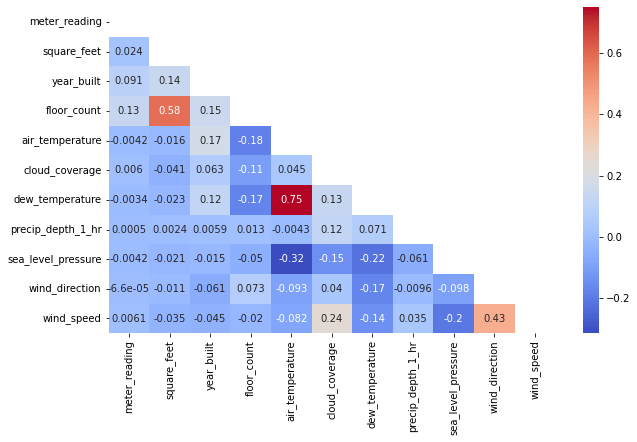

In [6]:
# General Correlations
# ANS: Following pairs may have multicollinearity: [Air temp and dew point] [floor_count and square feet] [wind direction and wind speed]
# ANS: we likely do not see correlation because we did not separate by meter type (0,1,2,3). Also there are middle weather configurations that may not requre energy use.
plt.figure(figsize=(10, 6))
c = ['timestamp', 'meter_reading', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
mask = np.triu(np.ones_like(df_train_combined[c].corr(), dtype=bool))
sns.heatmap(df_train_combined[c].corr(), annot=True, cmap = 'coolwarm', mask=mask)

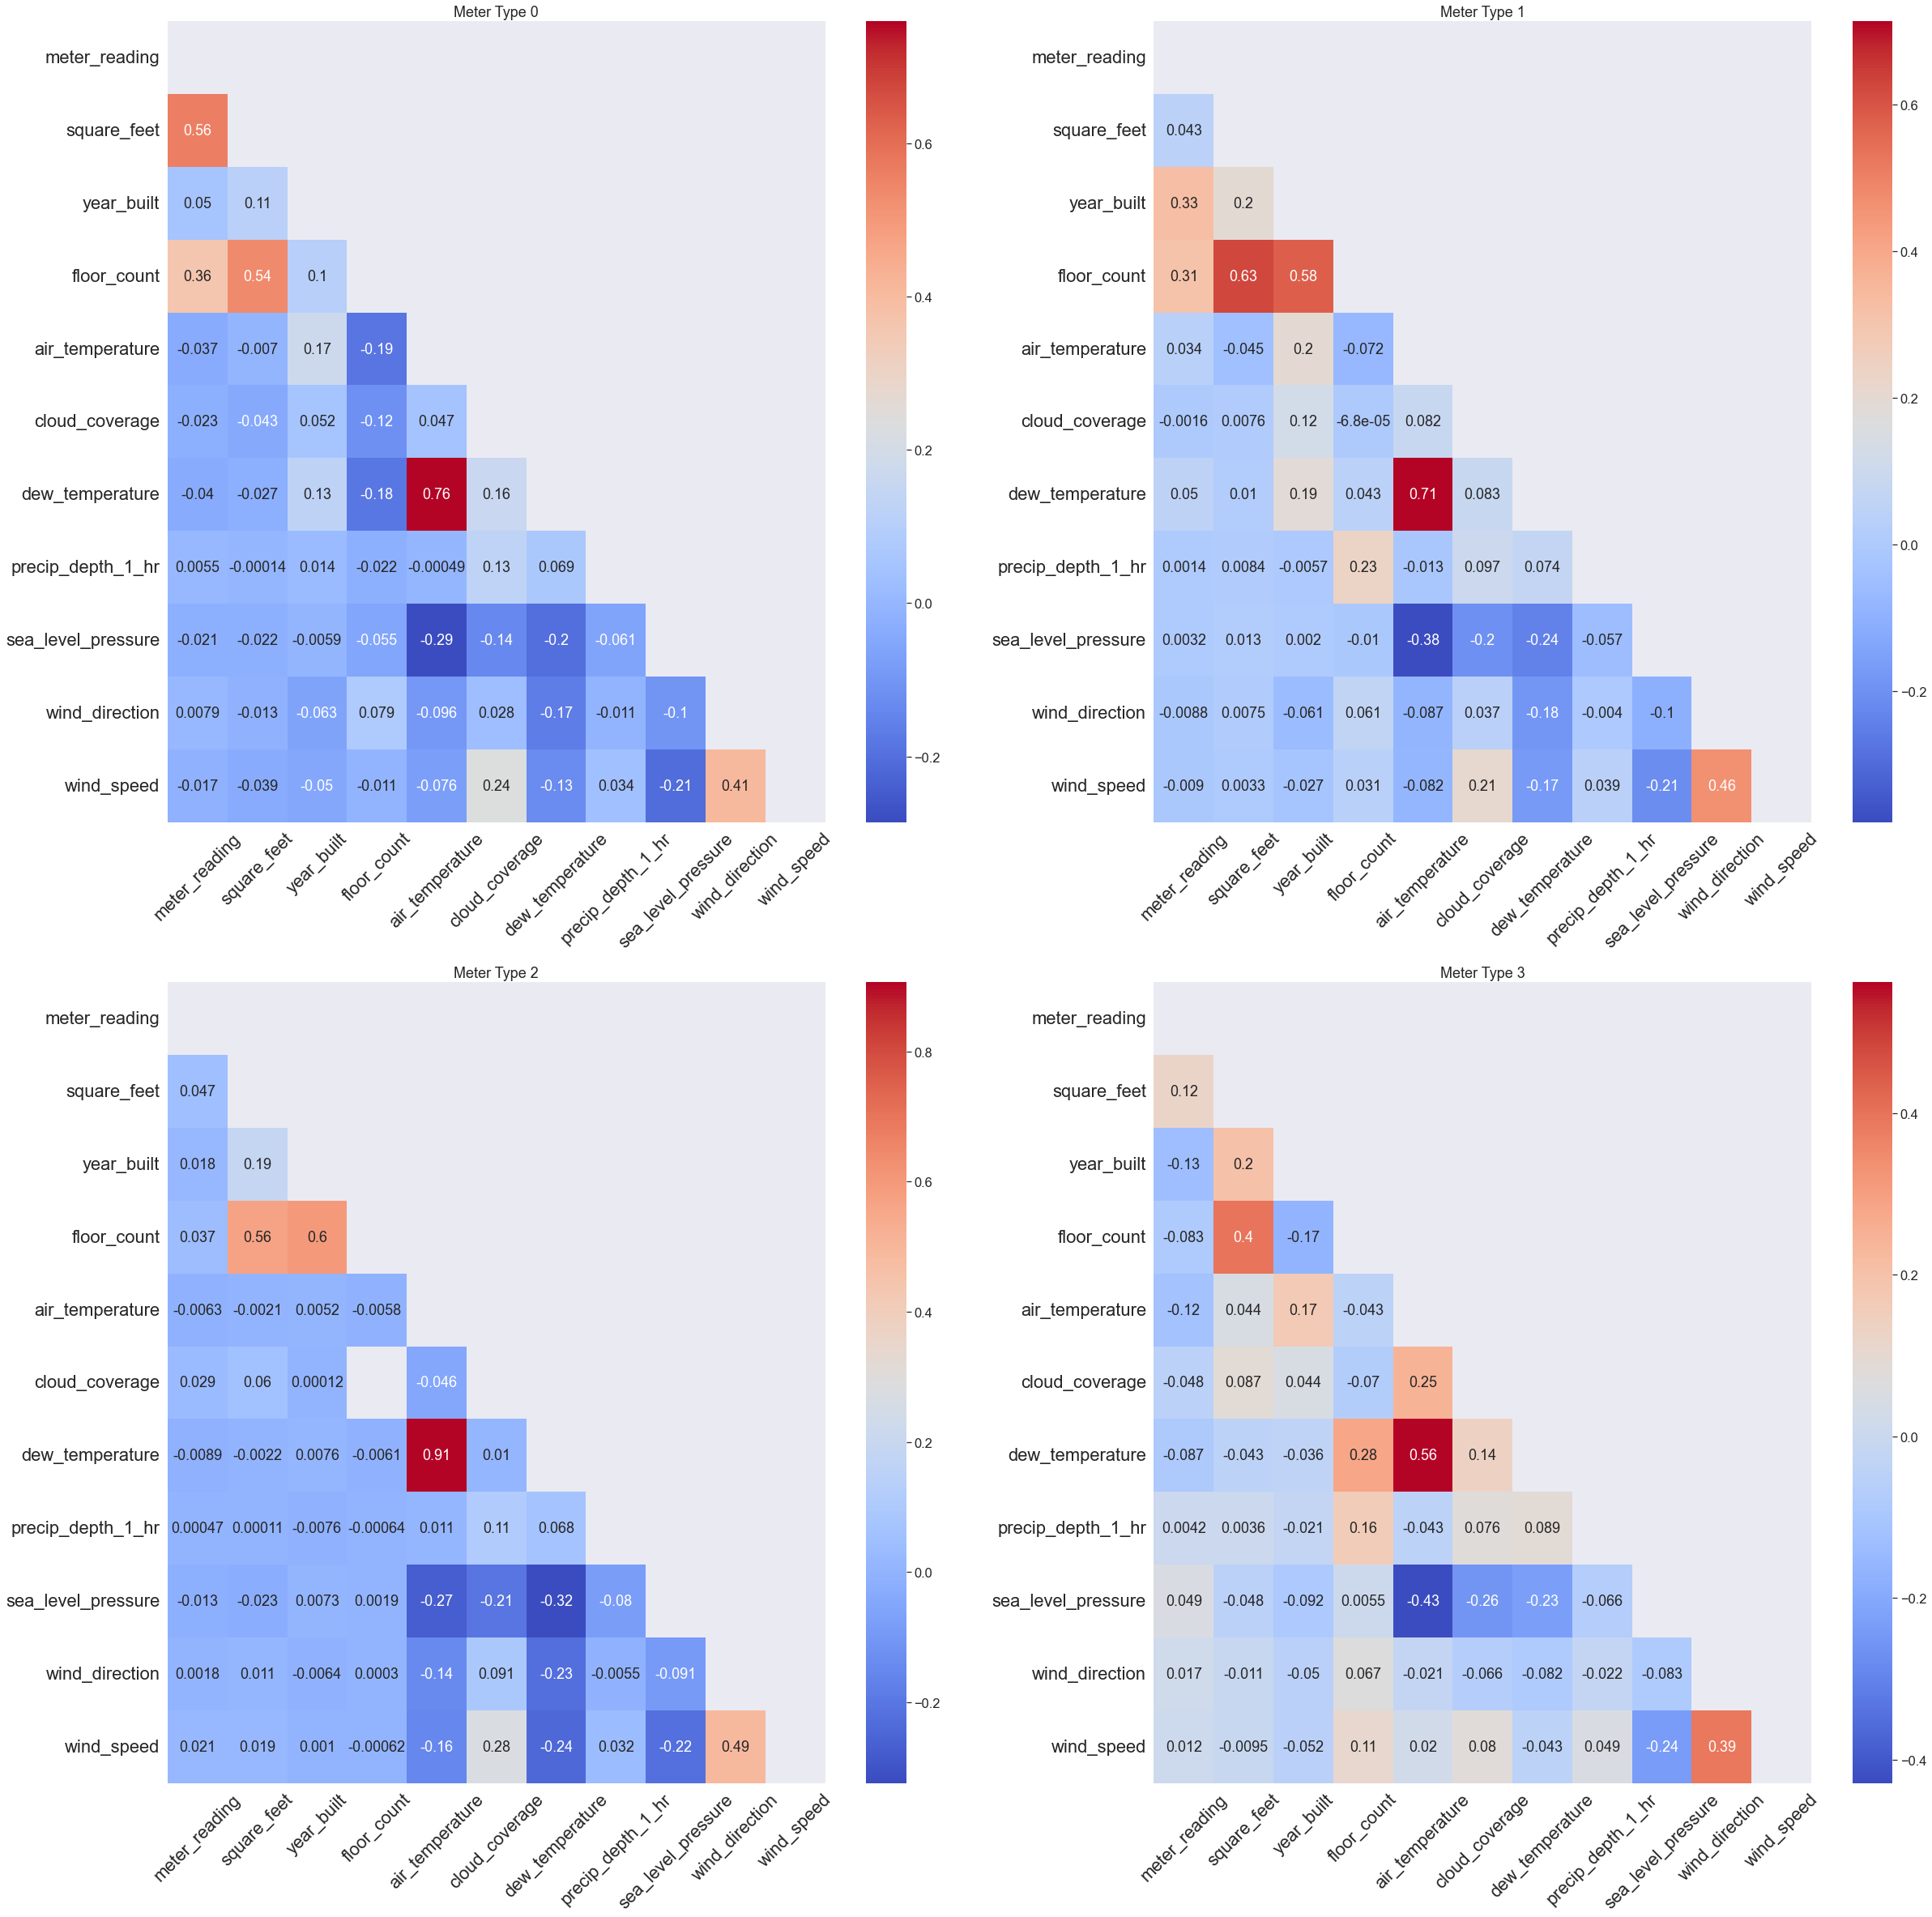

In [31]:
# General Correlations
# Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

fig, axes = plt.subplots(2, 2, figsize=(40, 40))

c = ['timestamp', 'meter_reading', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
sns.set(font_scale=1.5)

meter_type = 0
mask = np.triu(np.ones_like(df_train_combined[df_train_combined.meter==meter_type][c].corr(), dtype=bool))
sns.heatmap(df_train_combined[df_train_combined.meter==meter_type][c].corr(), annot=True, cmap = 'coolwarm', mask=mask, ax=axes[0, 0])
axes[0, 0].set_title(f'Meter Type {meter_type}')

meter_type = 1
mask = np.triu(np.ones_like(df_train_combined[df_train_combined.meter==meter_type][c].corr(), dtype=bool))
sns.heatmap(df_train_combined[df_train_combined.meter==meter_type][c].corr(), annot=True, cmap = 'coolwarm', mask=mask, ax=axes[0, 1])
axes[0, 1].set_title(f'Meter Type {meter_type}')

meter_type = 2
mask = np.triu(np.ones_like(df_train_combined[df_train_combined.meter==meter_type][c].corr(), dtype=bool))
sns.heatmap(df_train_combined[df_train_combined.meter==meter_type][c].corr(), annot=True, cmap = 'coolwarm', mask=mask, ax=axes[1, 0])
axes[1, 0].set_title(f'Meter Type {meter_type}')

meter_type = 3
mask = np.triu(np.ones_like(df_train_combined[df_train_combined.meter==meter_type][c].corr(), dtype=bool))
sns.heatmap(df_train_combined[df_train_combined.meter==meter_type][c].corr(), annot=True, cmap = 'coolwarm', mask=mask, ax=axes[1, 1])
axes[1, 1].set_title(f'Meter Type {meter_type}')

for ax in axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

In [41]:
# airtemp: Which require more energy?  +10C from normal or -10C from normal?       19C to 24C  = normal human comfort temp
# ANS: cold days = more steam and hot water.  hot days = more chilled water. 

# Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

low_temp_cutoff = FtoC(65)  #below 65F, heater turns on
high_temp_cutoff = FtoC(75)  #above 75F,  AC turns on

df_train_hot = df_train_combined[df_train_combined.air_temperature>high_temp_cutoff]
df_train_cold = df_train_combined[df_train_combined.air_temperature<low_temp_cutoff]
df_train_ok = df_train_combined[(df_train_combined.air_temperature>=low_temp_cutoff)&(df_train_combined.air_temperature<=high_temp_cutoff)]

for m in list(df_train_hot.meter.unique()):
    print(f'Meter {m} average reading on Hot days : {df_train_hot[df_train_hot.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on OK days  : {df_train_ok[df_train_ok.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Cold days: {df_train_cold[df_train_cold.meter==m].meter_reading.mean()}\n')

Meter 0 average reading on Hot days : 153.06490710973645
Meter 0 average reading on OK days  : 161.51378481421963
Meter 0 average reading on Cold days: 160.12165946835248

Meter 1 average reading on Hot days : 945.986413101301
Meter 1 average reading on OK days  : 901.3618068326658
Meter 1 average reading on Cold days: 350.0675999292184

Meter 3 average reading on Hot days : 152.6522667155327
Meter 3 average reading on OK days  : 214.08076839381553
Meter 3 average reading on Cold days: 566.6237914967538

Meter 2 average reading on Hot days : 5416.702402693255
Meter 2 average reading on OK days  : 13926.246074738117
Meter 2 average reading on Cold days: 17426.57794757432



In [53]:
# dew temp: if dew = air, = high humidity.  = more energy
# ANS: high dew = lots of chilled water! 

# Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

display( df_train_combined.dew_temperature.describe())
low_temp_cutoff = 8  #below 8C = ~ below 40% of time
high_temp_cutoff = 10  #above 10C = ~above 60% of time

df_train_hotdew = df_train_combined[df_train_combined.dew_temperature>high_temp_cutoff]
df_train_colddew = df_train_combined[df_train_combined.dew_temperature<low_temp_cutoff]
df_train_okdew = df_train_combined[(df_train_combined.dew_temperature>=low_temp_cutoff)&(df_train_combined.dew_temperature<=high_temp_cutoff)]

for m in list(df_train_hot.meter.unique()):
    print(f'Meter {m} average reading on Hot Dew days : {df_train_hotdew[df_train_hotdew.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on OK Dew days  : {df_train_okdew[df_train_okdew.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Cold Dew days: {df_train_colddew[df_train_colddew.meter==m].meter_reading.mean()}\n')

count   20115960.00
mean           7.75
std           10.18
min          -35.00
25%            0.00
50%            8.90
75%           16.10
max           26.10
Name: dew_temperature, dtype: float64

Meter 0 average reading on Hot Dew days : 152.44815412229187
Meter 0 average reading on OK Dew days  : 145.07998295273063
Meter 0 average reading on Cold Dew days: 167.2046108436882

Meter 1 average reading on Hot Dew days : 1093.5274892896296
Meter 1 average reading on OK Dew days  : 531.9589044539746
Meter 1 average reading on Cold Dew days: 266.4824133703784

Meter 3 average reading on Hot Dew days : 168.23208246457338
Meter 3 average reading on OK Dew days  : 246.50461841836477
Meter 3 average reading on Cold Dew days: 499.2474849208103

Meter 2 average reading on Hot Dew days : 7565.49189577838
Meter 2 average reading on OK Dew days  : 27785.51927115188
Meter 2 average reading on Cold Dew days: 18599.66339334481



In [44]:
# cloud: confirm: high cloud + high air temp = low energy.  low cloud + low air temp = low energy.  Vice versa
# cloud_coverage = portion of the sky covered in clouds
# ANS: cloudy has an effect. however, >4.5 could mean other things such as rain, humidity

# Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

low_temp_cutoff = FtoC(65)  #below 65F, heater turns on
high_temp_cutoff = FtoC(75)  #above 75F,  AC turns on

df_train_hot = df_train_combined[df_train_combined.air_temperature>high_temp_cutoff]
df_train_cold = df_train_combined[df_train_combined.air_temperature<low_temp_cutoff]
df_train_ok = df_train_combined[(df_train_combined.air_temperature>=low_temp_cutoff)&(df_train_combined.air_temperature<=high_temp_cutoff)]

cloud_cutoff = 4.5
df_train_hot_cloudy = df_train_hot[df_train_hot.cloud_coverage > cloud_cutoff]
df_train_hot_nocloud = df_train_hot[df_train_hot.cloud_coverage <= cloud_cutoff]
df_train_cold_cloudy = df_train_cold[df_train_cold.cloud_coverage > cloud_cutoff]
df_train_cold_nocloud = df_train_cold[df_train_cold.cloud_coverage <= cloud_cutoff]
df_train_ok_cloudy = df_train_ok[df_train_ok.cloud_coverage > cloud_cutoff]
df_train_ok_nocloud = df_train_ok[df_train_ok.cloud_coverage <= cloud_cutoff]

for m in list(df_train_hot.meter.unique()):
    print(f'Meter {m} average reading on Hot Cloudy days : {df_train_hot_cloudy[df_train_hot_cloudy.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Hot Not Cloudy days : {df_train_hot_nocloud[df_train_hot_nocloud.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on OK Cloudy days  : {df_train_ok_cloudy[df_train_ok_cloudy.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on OK Not Cloudy days  : {df_train_ok_nocloud[df_train_ok_nocloud.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Cold Cloudy days: {df_train_cold_cloudy[df_train_cold_cloudy.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Cold Not Cloudy days: {df_train_cold_nocloud[df_train_cold_nocloud.meter==m].meter_reading.mean()}\n')

Meter 0 average reading on Hot Cloudy days : 135.60404957115543
Meter 0 average reading on Hot Not Cloudy days : 152.27099780662334
Meter 0 average reading on OK Cloudy days  : 134.3765452740554
Meter 0 average reading on OK Not Cloudy days  : 147.60790830158624
Meter 0 average reading on Cold Cloudy days: 122.93904876833143
Meter 0 average reading on Cold Not Cloudy days: 141.77951238218273

Meter 1 average reading on Hot Cloudy days : 952.3013807147366
Meter 1 average reading on Hot Not Cloudy days : 924.1495733417138
Meter 1 average reading on OK Cloudy days  : 732.7170732914619
Meter 1 average reading on OK Not Cloudy days  : 820.1427657437455
Meter 1 average reading on Cold Cloudy days: 304.32603794910295
Meter 1 average reading on Cold Not Cloudy days: 376.7003774226547

Meter 3 average reading on Hot Cloudy days : 29.24901267833753
Meter 3 average reading on Hot Not Cloudy days : 181.560594917353
Meter 3 average reading on OK Cloudy days  : 56.31338503657668
Meter 3 average read

In [62]:
# precip: high precip = low energy?  
# ANS: rain = more steam and hot water 

# Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

display( df_train_combined.precip_depth_1_hr.describe())
print(df_train_combined[df_train_combined.precip_depth_1_hr==0].shape)
print(df_train_combined[df_train_combined.precip_depth_1_hr>0].shape)
precip_cutoff = 0  #5.5% of the time it rains > 0

df_train_rain = df_train_combined[df_train_combined.precip_depth_1_hr>precip_cutoff]
df_train_no = df_train_combined[df_train_combined.precip_depth_1_hr<=precip_cutoff]

for m in list(df_train_hot.meter.unique()):
    print(f'Meter {m} average reading on Rainy days : {df_train_rain[df_train_rain.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Dry days  : {df_train_no[df_train_no.meter==m].meter_reading.mean()}\n')


count   16467077.00
mean           0.80
std            7.47
min           -1.00
25%            0.00
50%            0.00
75%            0.00
max          343.00
Name: precip_depth_1_hr, dtype: float64

(14517573, 16)
(856152, 16)
Meter 0 average reading on Rainy days : 185.43716718057726
Meter 0 average reading on Dry days  : 151.4185538007685

Meter 1 average reading on Rainy days : 626.8173587662044
Meter 1 average reading on Dry days  : 696.0326741345747

Meter 3 average reading on Rainy days : 605.9960283266792
Meter 3 average reading on Dry days  : 370.42733484643

Meter 2 average reading on Rainy days : 22010.261804877206
Meter 2 average reading on Dry days  : 16541.137652827572



In [64]:
# wind speed: high speed = low energy if hot and high energy if cold
# ANS: windy = more steam and hot water 

# Meter: {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

display( df_train_combined.wind_speed.describe())
ws_cutoff = 3.1  #median value

df_train_windy = df_train_combined[df_train_combined.wind_speed>ws_cutoff]
df_train_lesswind = df_train_combined[df_train_combined.wind_speed<=ws_cutoff]

for m in list(df_train_hot.meter.unique()):
    print(f'Meter {m} average reading on Windy days : {df_train_windy[df_train_windy.meter==m].meter_reading.mean()}')
    print(f'Meter {m} average reading on Less Windy days  : {df_train_lesswind[df_train_lesswind.meter==m].meter_reading.mean()}\n')


count   20072424.00
mean           3.38
std            2.27
min            0.00
25%            2.10
50%            3.10
75%            4.60
max           19.00
Name: wind_speed, dtype: float64

Meter 0 average reading on Windy days : 153.72680573292644
Meter 0 average reading on Less Windy days  : 162.89874603774493

Meter 1 average reading on Windy days : 579.540296976944
Meter 1 average reading on Less Windy days  : 670.8565528607699

Meter 3 average reading on Windy days : 413.61091306269344
Meter 3 average reading on Less Windy days  : 363.6455719586095

Meter 2 average reading on Windy days : 23597.360875573653
Meter 2 average reading on Less Windy days  : 7670.298044128296

